In [1]:
# compare the performance gain from tuning compared with choosing NN vs. boosted trees

In [1]:
import pandas as pd
tuned_agg_df = pd.read_csv("./results/tuned_aggregated_results_with_default_hparams.csv")


In [2]:
tuned_agg_df.head()

,Unnamed: 0,alg_name,dataset_name,Accuracy__test_median,Accuracy__test_mean,time__train_median,time__train_mean,dataset_name_count,Accuracy__test_mean_min,Accuracy__test_mean_max,...,normalized_F1__test_mean,F1_rank_mean,F1_rank_median,Log Loss__test_median,Log Loss__test_mean,Log Loss__test_mean_min,Log Loss__test_mean_max,normalized_Log Loss__test_mean,Log Loss_rank_mean,Log Loss_rank_median
0,0,CatBoost,openml__APSFailure__168868,0.994145,0.994013,6.412328,7.276401,10,0.970303,0.994500,...,0.979880,3.0,3.0,0.018329,0.018939,0.017652,0.624879,0.002121,3.0,2.0
1,1,CatBoost,openml__Amazon_employee_access__34539,0.946903,0.947359,1.708439,1.729567,10,0.928927,0.952150,...,0.793690,5.0,4.0,0.156969,0.156347,0.155615,1.020650,0.000847,2.0,2.0
2,2,CatBoost,openml__Australian__146818,0.869565,0.872464,1.347650,1.393643,10,0.601449,0.872464,...,1.000000,1.0,3.0,0.290150,0.302677,0.302677,1.682198,0.000000,1.0,1.0
3,3,CatBoost,openml__Bioresponse__9910,0.798940,0.795521,5.815126,6.748842,10,0.727272,0.796848,...,0.980938,2.0,2.0,0.455072,0.456102,0.451718,0.967133,0.008506,4.0,1.0
4,4,CatBoost,openml__Census-Income__168340,0.958869,0.958658,830.825629,857.921920,10,0.943238,0.958658,...,1.000000,1.0,1.0,0.109673,0.109425,0.109108,0.474823,0.000866,2.0,2.0


In [29]:
metafeatures = pd.read_csv("../TabSurvey/metafeatures.csv")


In [31]:
[c for c in metafeatures.columns if "nr_inst" in c]

['f__pymfe.general.nr_inst']

In [37]:
(metafeatures["f__pymfe.general.nr_inst"] < 200).value_counts()

False    1600
True      230
Name: f__pymfe.general.nr_inst, dtype: int64

In [33]:
metafeatures

,dataset_name,f__pymfe.landmarking.best_node.count,f__pymfe.landmarking.best_node.count.relative,f__pymfe.landmarking.best_node.histogram.0,f__pymfe.landmarking.best_node.histogram.0.relative,f__pymfe.landmarking.best_node.histogram.1,f__pymfe.landmarking.best_node.histogram.1.relative,f__pymfe.landmarking.best_node.histogram.2,f__pymfe.landmarking.best_node.histogram.2.relative,f__pymfe.landmarking.best_node.histogram.3,...,f__pymfe.relative.worst_node.quantiles.4,f__pymfe.relative.worst_node.quantiles.4.relative,f__pymfe.relative.worst_node.range,f__pymfe.relative.worst_node.range.relative,f__pymfe.relative.worst_node.sd,f__pymfe.relative.worst_node.sd.relative,f__pymfe.relative.worst_node.skewness,f__pymfe.relative.worst_node.skewness.relative,f__pymfe.statistical.iq_range,f__pymfe.statistical.t_mean
0,openml__cjs__14967__fold_0,10,4.0,0.3,6.5,0.0,2.5,0.2,6.5,0.2,...,0.166667,1.0,0.000000,1.0,2.925695e-17,1.0,NaN,7.0,NaN,NaN
1,openml__cjs__14967__fold_1,10,4.0,0.1,4.0,0.0,3.0,0.0,2.5,0.2,...,0.171573,1.0,0.007937,1.0,1.912000e-03,1.0,1.025611,7.0,NaN,NaN
2,openml__cjs__14967__fold_2,10,4.0,0.3,7.0,0.1,5.5,0.1,4.5,0.0,...,0.166667,1.0,0.000000,1.0,2.925695e-17,1.0,NaN,7.0,NaN,NaN
3,openml__cjs__14967__fold_3,10,4.0,0.1,3.5,0.1,4.5,0.1,6.0,0.3,...,0.166667,1.0,0.000000,1.0,2.925695e-17,1.0,NaN,7.0,NaN,NaN
4,openml__cjs__14967__fold_4,10,4.0,0.1,3.5,0.1,6.5,0.1,5.5,0.4,...,0.171970,1.0,0.010497,1.0,2.801491e-03,1.0,-0.045710,5.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1825,openml__PhishingWebsites__14952__fold_5,0,4.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,...,NaN,7.0,NaN,7.0,NaN,7.0,NaN,7.0,NaN,NaN
1826,openml__PhishingWebsites__14952__fold_6,0,4.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,...,NaN,7.0,NaN,7.0,NaN,7.0,NaN,7.0,NaN,NaN
1827,openml__PhishingWebsites__14952__fold_7,0,4.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,...,NaN,7.0,NaN,7.0,NaN,7.0,NaN,7.0,NaN,NaN
1828,openml__PhishingWebsites__14952__fold_8,0,4.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,...,NaN,7.0,NaN,7.0,NaN,7.0,NaN,7.0,NaN,NaN


In [3]:
# categorize each alg

neural_algs = [
    "MLP",
    "TabNet",
    "VIME",
    "TabTransformer",
    "NODE",
    "STG",
    "NAM",
    "DeepFM",
    "SAINT",
    "DANet",
    "rtdl_MLP",
    "rtdl_ResNet",
    "rtdl_FTTransformer",
]

tree_algs = [
    "LightGBM",
    "XGBoost",
    "CatBoost"
]

tuned_agg_df.loc[:, "alg_type"] = "baseline"
tuned_agg_df.loc[tuned_agg_df["alg_name"].isin(neural_algs), "alg_type"] = "neural"
tuned_agg_df.loc[tuned_agg_df["alg_name"].isin(tree_algs), "alg_type"] = "trees"


In [4]:
# get the best performance for each alg type for each dataset

import numpy as np

dataset_list = tuned_agg_df["dataset_name"].unique()

nn_tree_diff = {}

for metric in ["Accuracy", "Log Loss", "F1"]:
    nn_tree_diff[metric] = []
    grouped_tuned = tuned_agg_df.groupby(["alg_type", "dataset_name"])[f"normalized_{metric}__test_mean"].agg(["max", "min"]).reset_index()
    for dataset in dataset_list:
        if metric == "Log Loss":
            get_col = "min"
        else:
            get_col = "max"

        tree_metric = grouped_tuned[(grouped_tuned["alg_type"] == "trees") & (grouped_tuned["dataset_name"] == dataset)][get_col].values
        nn_metric = grouped_tuned[(grouped_tuned["alg_type"] == "neural") & (grouped_tuned["dataset_name"] == dataset)][get_col].values

        if len(tree_metric) == 1 & len(nn_metric) == 1:
            nn_tree_diff[metric].append(nn_metric[0] - tree_metric[0])
        else:
            print(f"could not get result for dataset {dataset}")
            nn_tree_diff[metric].append(np.nan)


In [5]:
# for each dataset and each alg, (and each metric) get the difference in metric between the tuned alg and the default hparams

catboost_ll_metric_diff = {}
xgb_ll_metric_diff = {}
rtdl_resnet_ll_metric_diff = {}
for metric in ["Accuracy", "Log Loss", "F1"]:
    catboost_ll_metric_diff[metric] = []
    xgb_ll_metric_diff[metric] = []
    rtdl_resnet_ll_metric_diff[metric] = []
    for dataset in dataset_list:
        df = tuned_agg_df.loc[tuned_agg_df["dataset_name"] == dataset, :]
        # get the impact of tuning for catboost
        c_untuned = df.loc[df["alg_name"] == "CatBoost_default", f"normalized_{metric}__test_mean"].values
        c_tuned = df.loc[df["alg_name"] == "CatBoost", f"normalized_{metric}__test_mean"].values
        if len(c_untuned) == 1 & len(c_tuned) == 1:
            catboost_ll_metric_diff[metric].append(c_tuned[0] - c_untuned[0])
        else:
            print(f"no result for CatBoost for dataset {dataset}...")
            catboost_ll_metric_diff[metric].append(np.nan)

        # get the impact of tuning for xgb
        x_untuned = df.loc[df["alg_name"] == "XGBoost_default", f"normalized_{metric}__test_mean"].values
        x_tuned = df.loc[df["alg_name"] == "XGBoost", f"normalized_{metric}__test_mean"].values
        if len(x_untuned) == 1 & len(x_tuned) == 1:
            xgb_ll_metric_diff[metric].append(x_tuned[0] - x_untuned[0])
        else:
            print(f"no result for XGB for dataset {dataset}...")
            xgb_ll_metric_diff[metric].append(np.nan)


        # get the difference of tuning for rtdl-ResNet
        r_untuned = df.loc[df["alg_name"] == "rtdl_ResNet_default", f"normalized_{metric}__test_mean"].values
        r_tuned = df.loc[df["alg_name"] == "rtdl_ResNet", f"normalized_{metric}__test_mean"].values
        if len(r_untuned) == 1 & len(r_tuned) == 1:
            rtdl_resnet_ll_metric_diff[metric].append(r_tuned[0] - r_untuned[0])
        else:
            print(f"no result for rtdl_resnet for dataset {dataset}...")
            rtdl_resnet_ll_metric_diff[metric].append(np.nan)

    # catboost_ll_metric_diff = 
# tuned_agg_df.groupby(["dataset_name", "alg_name"])["normalized_Log Loss__test_mean"]

no result for rtdl_resnet for dataset openml__APSFailure__168868...
no result for rtdl_resnet for dataset openml__Click_prediction_small__190408...
no result for rtdl_resnet for dataset openml__LED-display-domain-7digit__125921...
no result for rtdl_resnet for dataset openml__MiniBooNE__168335...
no result for rtdl_resnet for dataset openml__Satellite__167211...
no result for rtdl_resnet for dataset openml__adult__7592...
no result for rtdl_resnet for dataset openml__blood-transfusion-service-center__145836...
no result for rtdl_resnet for dataset openml__breast-w__15...
no result for rtdl_resnet for dataset openml__chess__3952...
no result for rtdl_resnet for dataset openml__dilbert__168909...
no result for rtdl_resnet for dataset openml__ecoli__145977...
no result for rtdl_resnet for dataset openml__eeg-eye-state__14951...
no result for rtdl_resnet for dataset openml__fabert__168910...
no result for rtdl_resnet for dataset openml__fertility__9984...
no result for rtdl_resnet for data

In [6]:
# here are the two sets of values we will plot
print("difference for tuning (catboost) | difference from tuning (resnet) | difference between NN and trees")
for i, dataset in enumerate(dataset_list):
    print(f"{dataset:40s} : {catboost_ll_metric_diff[metric][i]:.3f} | {rtdl_resnet_ll_metric_diff[metric][i]:.3f} | {nn_tree_diff[metric][i]:.3f}")

difference for tuning (catboost) | difference from tuning (resnet) | difference between NN and trees
openml__APSFailure__168868               : 0.058 | nan | -0.114
openml__Amazon_employee_access__34539    : 0.058 | 0.095 | -0.076
openml__Australian__146818               : 0.027 | 0.016 | -0.037
openml__Bioresponse__9910                : 0.180 | 0.268 | -0.264
openml__Census-Income__168340            : 0.032 | 0.018 | -0.270
openml__Click_prediction_small__190408   : 0.000 | nan | -0.016
openml__Fashion-MNIST__146825            : 0.037 | -0.000 | -0.006
openml__GesturePhaseSegmentationProcessed__14969 : 0.139 | 0.073 | -0.216
openml__Internet-Advertisements__167125  : 0.017 | 0.950 | 0.014
openml__JapaneseVowels__3510             : 0.009 | 0.003 | 0.004
openml__LED-display-domain-7digit__125921 : 0.072 | nan | 0.023
openml__MagicTelescope__3954             : 0.000 | 0.016 | -0.011
openml__MiceProtein__146800              : 0.045 | 0.007 | 0.021
openml__MiniBooNE__168335                

Text(0, 0.5, 'F1: Abs. diff between NN and tree')

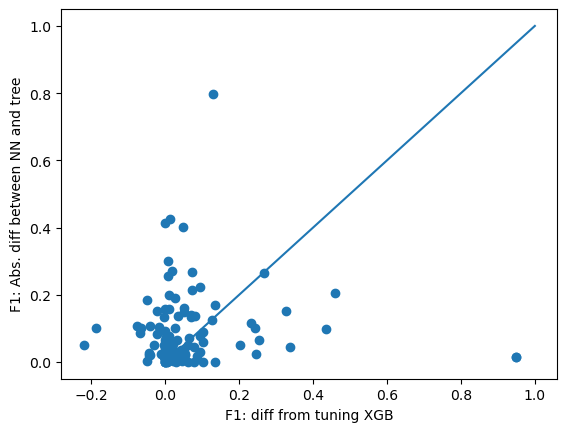

In [90]:
# now plot these two... 
import matplotlib.pyplot as plt

metric = "F1"
plt.scatter(rtdl_resnet_ll_metric_diff[metric], np.abs(nn_tree_diff[metric]))
# plt.scatter(rtdl_resnet_ll_metric_diff[metric], np.abs(nn_tree_diff[metric]))
plt.plot([0, 1], [0, 1])
plt.xlabel(f"{metric}: diff from tuning XGB")
plt.ylabel(f"{metric}: Abs. diff between NN and tree")

total_num = np
print(f"number of cases where abs-diff between NNs and trees is less than tuning from XGB:")

In [26]:
# np.sum()

non_nan = ~np.isnan(catboost_ll_metric_diff[metric] - np.array(nn_tree_diff[metric]))
num_tune_larger = np.sum(np.array(catboost_ll_metric_diff[metric])[non_nan] > np.array(nn_tree_diff[metric])[non_nan])
num_nn_tree_larger = np.sum(np.array(catboost_ll_metric_diff[metric])[non_nan] <= np.array(nn_tree_diff[metric])[non_nan])
print("num datasets where tuning has larger diff:")
print(f"{100 * float(num_tune_larger) / (num_tune_larger + num_nn_tree_larger):.2f} ({num_tune_larger} of {num_tune_larger + num_nn_tree_larger})")
print("num where tree-vs-nn is larger diff:")
print(f"{100 * float(num_nn_tree_larger) / (num_tune_larger + num_nn_tree_larger):.2f} ({num_nn_tree_larger} of {num_tune_larger + num_nn_tree_larger})")



num datasets where tuning has larger diff:
69.14 (112 of 162)
num where tree-vs-nn is larger diff
30.86 (50 of 162)
